In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/asteroid-dataset/dataset.csv


In [3]:
file_path = '/kaggle/input/asteroid-dataset/dataset.csv'

In [4]:
dtype_spec = {
    'full_name': str,
    'pdes': str,
    'name': str
}

asteroid_df = pd.read_csv(file_path, dtype=dtype_spec, low_memory=False)
asteroid_df.head()

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [5]:
asteroid_df2 = asteroid_df.copy() #for use with feature selection below

asteroid_df2['neo'] = asteroid_df2['neo'].apply(lambda x: 1 if x == 'Y' else 0).astype('int64') #convert neo to 0s and 1s

print("Unique values in 'neo' column after encoding:")
print(asteroid_df2['neo'].value_counts())

print("Data type of 'neo' column:", asteroid_df2['neo'].dtype)

Unique values in 'neo' column after encoding:
neo
0    935629
1     22895
Name: count, dtype: int64
Data type of 'neo' column: int64


In [6]:
asteroid_df3 = asteroid_df.copy() #for use with ml model below

asteroid_df3['neo'] = asteroid_df3['neo'].apply(lambda x: 1 if x == 'Y' else 0).astype('int64') #convert neo to 0s and 1s

columns_of_interest = ['q', 'moid_ld', 'diameter', 'neo'] #top features found from the random classifier below to predict neo

asteroid_df3 = asteroid_df3[columns_of_interest].dropna() #drop NaNs

print("Head of the selected columns:")
print(asteroid_df3[columns_of_interest].head())

print("\nData types of the selected columns:")
print(asteroid_df3[columns_of_interest].dtypes)

Head of the selected columns:
          q     moid_ld  diameter  neo
0  2.558684  620.640533   939.400    0
1  2.135935  480.348639   545.000    0
2  1.982706  402.514639   246.596    0
3  2.151909  443.451432   525.400    0
4  2.082619  426.433027   106.699    0

Data types of the selected columns:
q           float64
moid_ld     float64
diameter    float64
neo           int64
dtype: object


In [7]:
#when neo is 1
print("Head of the selected columns where neo is equal to 1:")
print(asteroid_df3[asteroid_df3['neo'] == 1].head())

Head of the selected columns where neo is equal to 1:
             q     moid_ld  diameter  neo
432   1.132973   57.839613    16.840    1
886   1.062886   31.996351     4.200    1
1035  1.244303  134.246527    37.675    1
1220  1.083970   41.816706     1.000    1
1565  0.186500   13.327010     1.000    1


In [8]:
#when neo is 0
print("Head of the selected columns where neo is equal to 0:")
print(asteroid_df3[asteroid_df3['neo'] == 0].head())

Head of the selected columns where neo is equal to 0:
          q     moid_ld  diameter  neo
0  2.558684  620.640533   939.400    0
1  2.135935  480.348639   545.000    0
2  1.982706  402.514639   246.596    0
3  2.151909  443.451432   525.400    0
4  2.082619  426.433027   106.699    0


In [9]:
column_names = asteroid_df.columns
column_names

Index(['id', 'spkid', 'full_name', 'pdes', 'name', 'prefix', 'neo', 'pha', 'H',
       'diameter', 'albedo', 'diameter_sigma', 'orbit_id', 'epoch',
       'epoch_mjd', 'epoch_cal', 'equinox', 'e', 'a', 'q', 'i', 'om', 'w',
       'ma', 'ad', 'n', 'tp', 'tp_cal', 'per', 'per_y', 'moid', 'moid_ld',
       'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w',
       'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'class',
       'rms'],
      dtype='object')

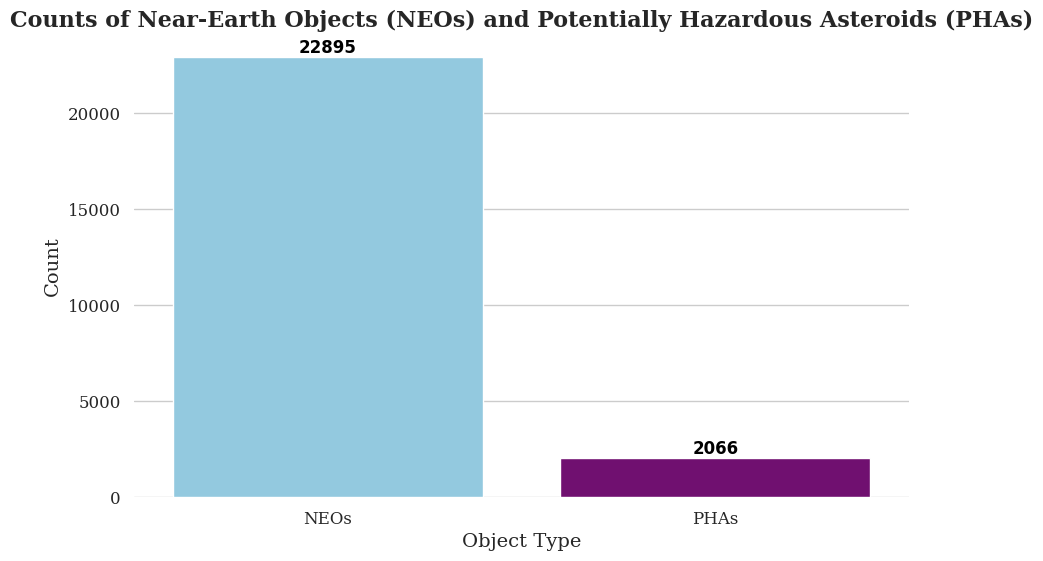

In [10]:
#bar chart of neo and pha 
neo_count = asteroid_df['neo'].value_counts()
pha_count = asteroid_df['pha'].value_counts()

counts_df = pd.DataFrame({
    'Object Type': ['NEOs', 'PHAs'],
    'Count': [neo_count.get('Y', 0), pha_count.get('Y', 0)]
})

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Object Type', y='Count', data=counts_df, palette=['skyblue', 'purple'])

for index, row in counts_df.iterrows():
    bar_plot.text(index, row['Count'] + 0.1, int(row['Count']), color='black', ha="center", va="bottom", fontweight='bold')

plt.title('Counts of Near-Earth Objects (NEOs) and Potentially Hazardous Asteroids (PHAs)', fontsize=16, fontweight='bold', family='serif')
plt.ylabel('Count', fontsize=14, family='serif')
plt.xlabel('Object Type', fontsize=14, family='serif')

sns.despine(left=True, bottom=True)

plt.xticks(fontsize=12, family='serif')
plt.yticks(fontsize=12, family='serif')

plt.show()

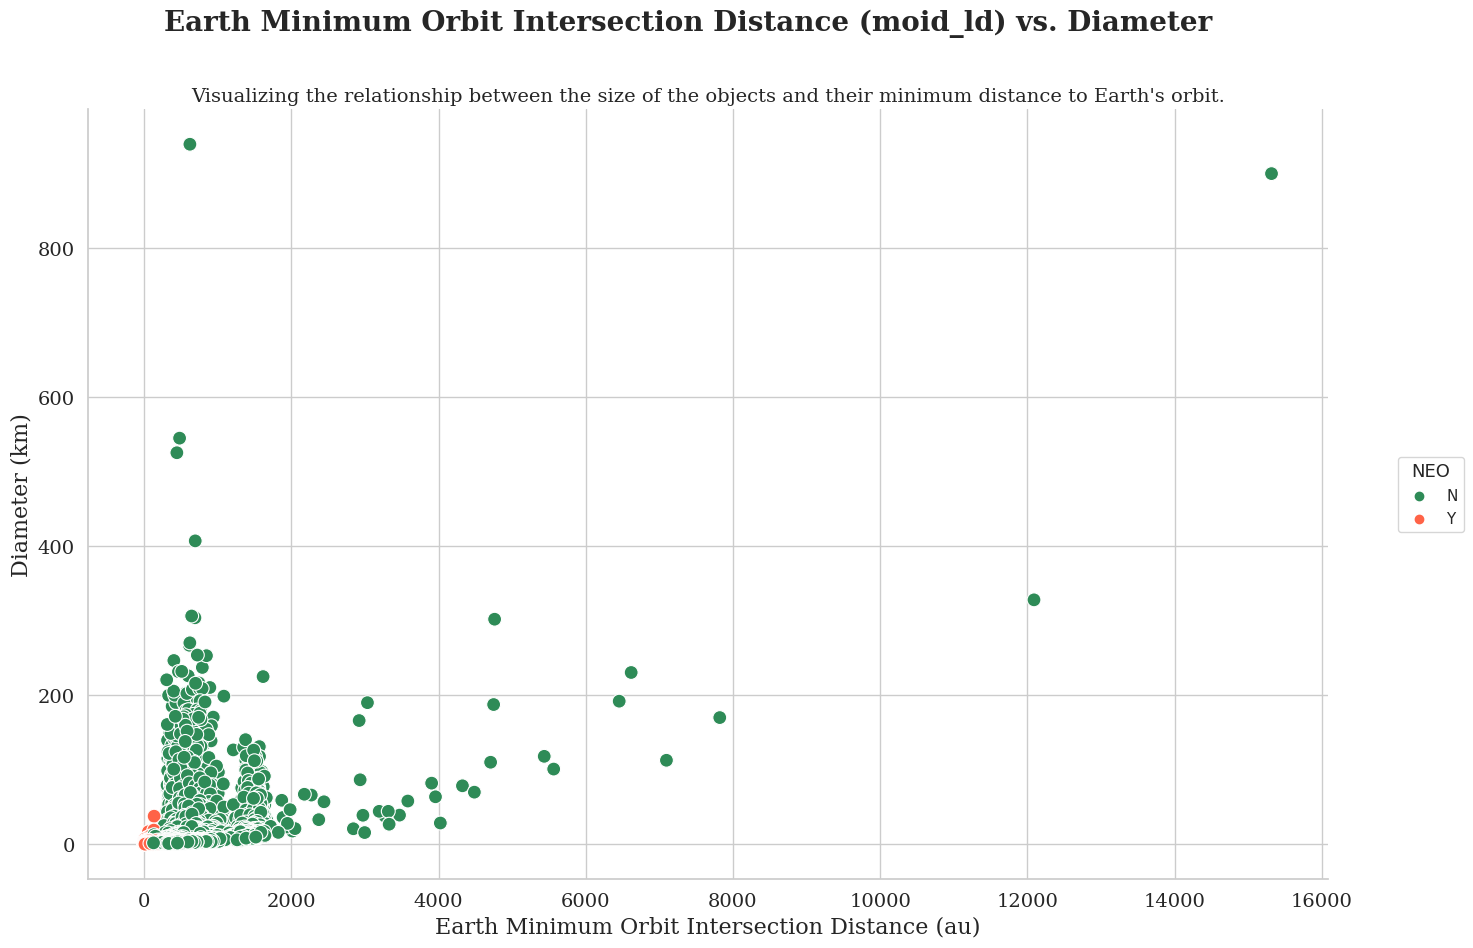

In [11]:
#scatter plot of Earth Minimum Orbit Intersection Distance (moid_ld) vs. diameter
plt.figure(figsize=(16, 10))

scatter_plot = sns.scatterplot(x='moid_ld', y='diameter', data=asteroid_df, hue='neo', palette=['#2E8B57', '#FF6347'], s=100)

plt.suptitle('Earth Minimum Orbit Intersection Distance (moid_ld) vs. Diameter', fontsize=20, fontweight='bold', family='serif')
plt.title('Visualizing the relationship between the size of the objects and their minimum distance to Earth\'s orbit.', fontsize=14, family='serif')

plt.xlabel('Earth Minimum Orbit Intersection Distance (au)', fontsize=16, family='serif')
plt.ylabel('Diameter (km)', fontsize=16, family='serif')

plt.xticks(fontsize=14, family='serif')
plt.yticks(fontsize=14, family='serif')

plt.legend(title='NEO', bbox_to_anchor=(1.05, 0.5), loc='center left', title_fontsize='13', fontsize='11')

sns.despine()

plt.show()

**#visualizing 'name' (Object IAU name) column**

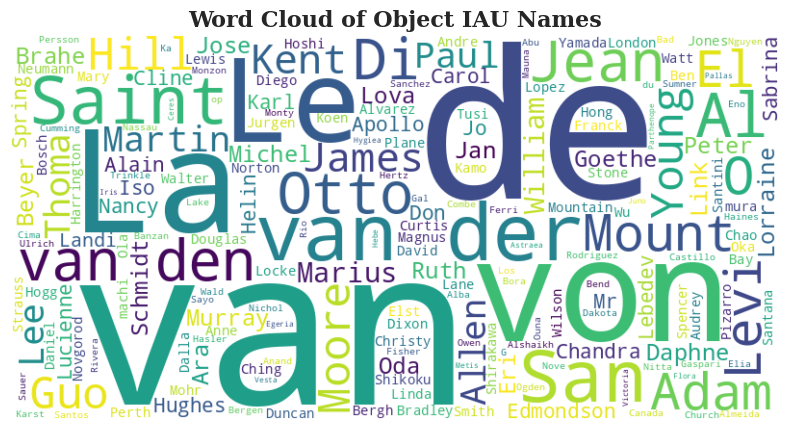

In [12]:
#word cloud
names_combined = " ".join(asteroid_df['name'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(names_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Object IAU Names', fontsize=16, fontweight='bold', family='serif')
plt.show()

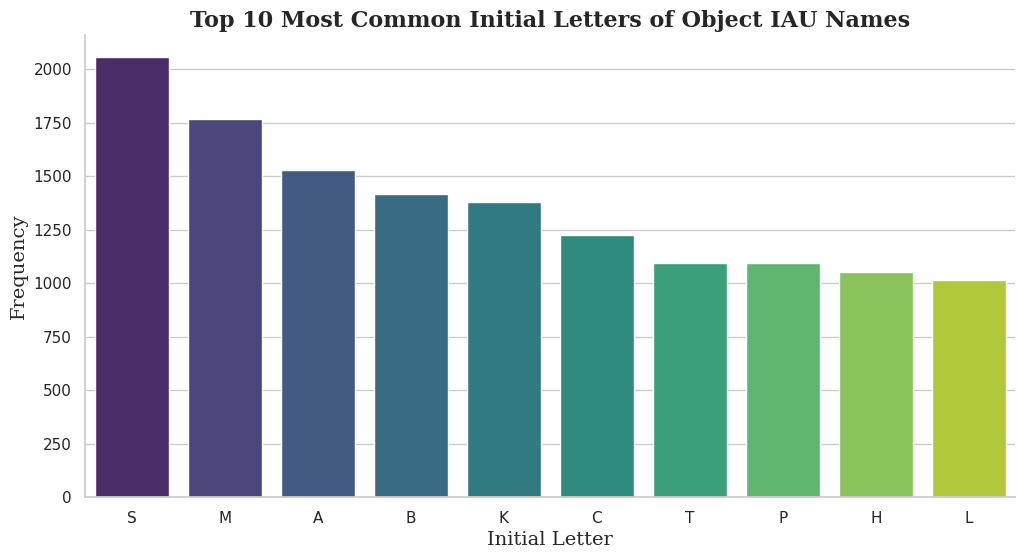

In [13]:
#bar chart of initial letter frequency
initial_letters = asteroid_df['name'].dropna().apply(lambda x: x[0])

initial_letter_counts = initial_letters.value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=initial_letter_counts.index, y=initial_letter_counts.values, palette='viridis')
plt.title('Top 10 Most Common Initial Letters of Object IAU Names', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Initial Letter', fontsize=14, family='serif')
plt.ylabel('Frequency', fontsize=14, family='serif')
sns.despine()
plt.show()

**Feature selection on asteroid_df2 to predict whether an object is Near-Earth Object (NEO) or not.**

**Potential Candidates:**

H (Absolute Magnitude): Represents the brightness of the object. Brighter objects might be more likely to be observed and categorized as NEOs or PHAs.

Diameter: The size of the object can be crucial in determining its potential hazard level.

Albedo: Reflectivity of the object. This can correlate with its composition and surface properties.

e (Eccentricity): Measures the deviation of the orbit from a perfect circle. Objects with highly eccentric orbits might have different interaction dynamics with Earth.

a (Semi-major Axis): Represents the object's orbit size. This can help in understanding the object's orbit and its potential to come close to Earth.

q (Perihelion Distance): The closest distance of the object to the Sun. Objects with smaller perihelion distances might have orbits that cross Earth's orbit.

i (Inclination): Angle of the orbit relative to the ecliptic plane. This can help in understanding how the object's orbit interacts with Earth's orbit.

moid_ld (Minimum Orbit Intersection Distance): The minimum distance between the object's orbit and Earth's orbit. This is a direct measure of how close the object can come to Earth.

Feature importances: [0.03915935 0.1350351  0.00145558 0.05532254 0.10181317 0.39336581
 0.0063409  0.26750755]


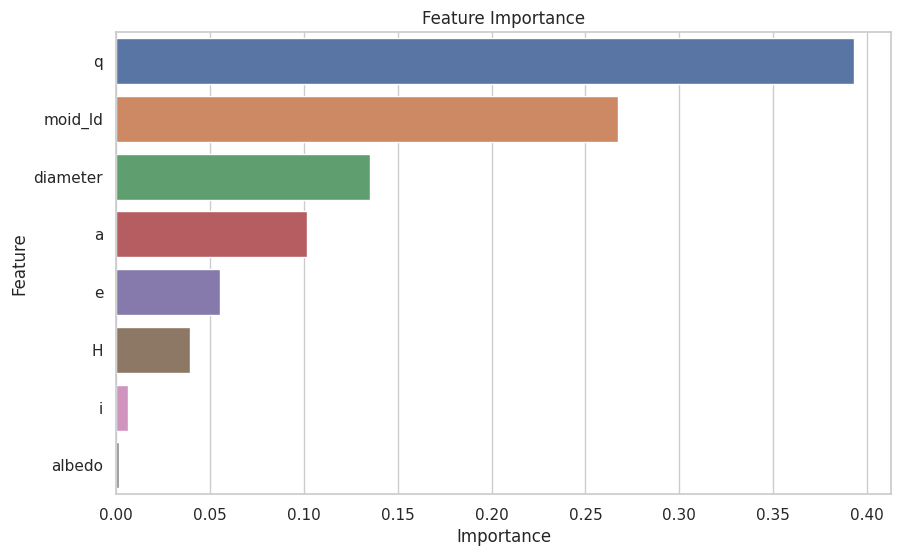

In [14]:
#feature importance using tree-based model - random forest
features = ['H', 'diameter', 'albedo', 'e', 'a', 'q', 'i', 'moid_ld']

asteroid_df2.dropna(subset=features, inplace=True)

scaler = StandardScaler()
X1 = scaler.fit_transform(asteroid_df2[features])
y1 = asteroid_df2['neo']

model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model1.fit(X1, y1)

importances = model1.feature_importances_
print("Feature importances:", importances)

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

'q', 'moid_ld', and 'diameter' appear to be the most important features to NEO.

**features:**

q: perihelion distance.

moid_ld: minimum Orbit Intersection Distance.

diameter: diameter of the object.

**target:**

neo: binary classification indicating whether an asteroid is a Near-Earth Object (NEO).

In [15]:
#prepare data for NN model
features_forNNModel = ['q', 'moid_ld', 'diameter']
X = asteroid_df3[features_forNNModel].values #features
y = asteroid_df3['neo'].values #target

#train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

#PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

#DataLoader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
#define the neural network neoNN
class neoNN(nn.Module):
    def __init__(self):
        super(neoNN, self).__init__()
        self.fc1 = nn.Linear(3, 256)         #input layer 3 neurons/3 features - maps the input to 256 neurons in the first hidden layer.
        self.bn1 = nn.BatchNorm1d(256)       #normalize the inputs to each layer - speeds up training/improves stability of the network.
        self.fc2 = nn.Linear(256, 128)       #first hidden layer maps 256 neurons to 128 neurons.
        self.bn2 = nn.BatchNorm1d(128)       #normalize the inputs to each layer - speeds up training/improves stability of the network.
        self.fc3 = nn.Linear(128, 64)        #second hidden layer maps 128 neurons to 64 neurons.
        self.bn3 = nn.BatchNorm1d(64)        #normalize the inputs to each layer - speeds up training/improves stability of the network.
        self.fc4 = nn.Linear(64, 32)         #third hidden layer maps 64 neurons to 32 neurons.
        self.bn4 = nn.BatchNorm1d(32)        #normalize the inputs to each layer - speeds up training/improves stability of the network.
        self.fc5 = nn.Linear(32, 1)          #maps the 32 neurons from the last hidden layer to a single neuron/binary classification.
        self.dropout = nn.Dropout(0.5)       #prevent overfitting by randomly setting half of the activations to zero during training.
        self.leaky_relu = nn.LeakyReLU(0.01) #avoids "dying ReLU" problem (where neurons get stuck during training/always output zero.
        self.sigmoid = nn.Sigmoid()          #sigmoid activation used in the output layer to squash output to a range between 0 and 1.
    
    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.sigmoid(self.fc5(x)) 
        return x

#initialize the model, loss function, and optimizer
model = neoNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [17]:
#train the model
num_epochs = 50
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    #early stopping - prevent the model from overfitting and save computational resources by stopping the training 
    #process once the model stops improving on the validation set
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'neo_nn_model.pth') #save the best model
        epochs_no_improve = 0 #reset counter if validation improves
    else:
        epochs_no_improve += 1 #increment counter if no improvement for patience number of epochs
        if epochs_no_improve >= patience:
            break

Epoch [1/50], Train Loss: 0.0632, Validation Loss: 0.0059
Epoch [2/50], Train Loss: 0.0117, Validation Loss: 0.0042
Epoch [3/50], Train Loss: 0.0088, Validation Loss: 0.0036
Epoch [4/50], Train Loss: 0.0075, Validation Loss: 0.0028
Epoch [5/50], Train Loss: 0.0067, Validation Loss: 0.0764
Epoch [6/50], Train Loss: 0.0057, Validation Loss: 0.0024
Epoch [7/50], Train Loss: 0.0066, Validation Loss: 0.0040
Epoch [8/50], Train Loss: 0.0053, Validation Loss: 0.0014
Epoch [9/50], Train Loss: 0.0060, Validation Loss: 0.0018
Epoch [10/50], Train Loss: 0.0047, Validation Loss: 0.0018
Epoch [11/50], Train Loss: 0.0052, Validation Loss: 0.0016
Epoch [12/50], Train Loss: 0.0051, Validation Loss: 0.0012
Epoch [13/50], Train Loss: 0.0057, Validation Loss: 0.0023
Epoch [14/50], Train Loss: 0.0055, Validation Loss: 0.0015
Epoch [15/50], Train Loss: 0.0061, Validation Loss: 0.0017
Epoch [16/50], Train Loss: 0.0048, Validation Loss: 0.0012
Epoch [17/50], Train Loss: 0.0047, Validation Loss: 0.0013
Epoch 

In [18]:
#load and evaluate the model
model_Z = neoNN()
model_Z.load_state_dict(torch.load('neo_nn_model.pth'))
model_Z.eval()

with torch.no_grad():
    outputs = model_Z(X_test_tensor)
    predicted = (outputs >= 0.5).float()
    accuracy = (predicted.eq(y_test_tensor).sum() / y_test_tensor.shape[0]).item()
    print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 99.95%


In [19]:
#test out the model's predictions with new dummy data

#dummy data where neo is equal to 1
neo_1_examples = [
    [1.132973, 57.839613, 16.840],
    [1.062886, 31.996351, 4.200],
    [1.244303, 134.246527, 37.675],
    [1.083970, 41.816706, 1.000],
    [0.186500, 13.327010, 1.000]
]

#dummy data where neo is equal to 0
neo_0_examples = [
    [2.558684, 620.640533, 939.400],
    [2.135935, 480.348639, 545.000],
    [1.982706, 402.514639, 246.596],
    [2.151909, 443.451432, 525.400],
    [2.082619, 426.433027, 106.699]
]

#try dummy data examples
def test_model(model, examples):
    model.eval()
    with torch.no_grad():
        for example in examples:
            data = torch.tensor([example], dtype=torch.float32)
            prediction = model(data)
            predicted_class = (prediction >= 0.5).float().item()
            status = 'Yes' if predicted_class == 1.0 else 'No'
            print(f'Input: {example} -> Predicted NEO status: {status}')

print("Testing examples where neo is expected to be 1 (Yes):")
test_model(model_Z, neo_1_examples)

print("\nTesting examples where neo is expected to be 0 (No):")
test_model(model_Z, neo_0_examples)

Testing examples where neo is expected to be 1 (Yes):
Input: [1.132973, 57.839613, 16.84] -> Predicted NEO status: Yes
Input: [1.062886, 31.996351, 4.2] -> Predicted NEO status: Yes
Input: [1.244303, 134.246527, 37.675] -> Predicted NEO status: Yes
Input: [1.08397, 41.816706, 1.0] -> Predicted NEO status: Yes
Input: [0.1865, 13.32701, 1.0] -> Predicted NEO status: Yes

Testing examples where neo is expected to be 0 (No):
Input: [2.558684, 620.640533, 939.4] -> Predicted NEO status: No
Input: [2.135935, 480.348639, 545.0] -> Predicted NEO status: No
Input: [1.982706, 402.514639, 246.596] -> Predicted NEO status: No
Input: [2.151909, 443.451432, 525.4] -> Predicted NEO status: No
Input: [2.082619, 426.433027, 106.699] -> Predicted NEO status: No
